# Scales and Models for Feedback Bubbles

In this notebook we will provide definitions and discussions of the relevant physical scales for the feedback mechanisms of stellar winds and photo-ionized gas pressure due to massive stars in star-forming regions. These scales are written out as code in `quantities.py` using `astropy.units` and we will call on these to make some comparison plots.

We also have implemented several models for the evolution of feedback bubbles (FBs) from this feedback, contained within `fb_models.py` which will also be explained here.

This code is meant as a reference and a way for interested readers of Lancaster et al. 2025a to easily explore the parameter space of the Co-Evolution Models described in that work and towards the end of this notebook (along with other simplified feedback models). Throughout the notebook below we will give equation numbers for certain quantities which reference the corresponding definitions in Lancaster+25a.

In [1]:
# some libraries we will need
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as ac

import quantities
import sfe_prescriptions as sfes
import fb_models

# Photo-Ionized Gas

The radius of a bubble of gas of uniform density that is ionized by a central source is given by the Strömgren radius as (Equation 12 & B16)

$R_{\rm St} \equiv \left(\frac{3 Q_0}{4\pi \overline{n}_{\rm H}^2 \alpha_B} \right)^{1/3} = 10.1 \, {\rm pc} 
    \left( \frac{Q_0}{4 \times 10^{50}\, {\rm s}^{-1}}\right)^{1/3}
    \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-2/3}$

where $Q_0$ is the ionizing photon rate, $\overline{n}_{\rm H}$ is the mean density of Hydrogen nuclei in the medium, and $\alpha_B$ is the so called "case B" recombination rate, which we have taken to be $3.11 \times 10^{-13}\, {\rm cm^3}\, {\rm s}^{-1}$ the vale of which is taken from Glover et al. 2010 for gas at a temperature of $T = 8000\, {\rm K}$.

We can calculate the above using the definition of this radius in `quantities.py` as

In [2]:
Q0 = 4e50/u.s
nH = 100/(u.cm**3)
quantities.RSt(Q0, nH)

<Quantity 10.14814006 pc>

$\alpha_B$ is an optional keyword argument to the above function so we could change it as

In [3]:
Q0 = 4e50/u.s
nH = 100/(u.cm**3)
aB = 2e-13*u.cm**3/u.s
quantities.RSt(Q0, nH, alphaB=aB)

<Quantity 11.75700177 pc>

The units of the arguments to these functions are checked, so if you mess up it will tell you:

In [4]:
Q0 = 4e50*u.km/u.s # changed units
nH = 100/(u.cm**3)
aB = 2e-13*u.cm**3/u.s
quantities.RSt(Q0, nH, alphaB=aB)

ValueError: Units of Q0 are incorrect

This bubble of ionized gas is established on the time-scale it takes to emit enough photons to ionize the whole region (Equation B15)

$t_{\rm rec} \equiv \overline{n}_{\rm H}\frac{4\pi}{3Q_0}R_{\rm St}^3 = \left(\overline{n}_{\rm H}\alpha_B \right)^{-1}
        = 1.02 \times 10^3 \, {\rm yr} \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-1}$

Notice that this is the same time scale that it would take this volume to recombine, which comes from the fact that the volume is defined by ionization-recombination equilibirum. We can calculte the above as

In [5]:
nH = 100/(u.cm**3)
quantities.Trec(nH).to(u.yr)

<Quantity 1018.90957601 yr>

Once the Strömgren Sphere is established, in an "R-type" fashion, the photo-ionized gas bubble expands dynamically in a "D-type" fashion following the Spitzer-like solution of Hoskawa & Inutsuka of (Equation 16)

$R_{\rm Sp}= R_{\rm St}\left(1 + \frac{7}{4} \frac{t}{t_{d,i,0}} \right)^{4/7}$

where in the above, the D-type expansion is understood to begin at $t=0$. In the above the initial dynamical expansion time of the bubble is given as (Equation 17 & B17)

$t_{d,i,0} \equiv \frac{R_{\rm Sp}(t=0)}{\dot{R}_{\rm Sp}(t=0)} = \frac{\sqrt{3}}{2}\frac{R_{\rm St}}{c_i}
    = 8.59 \times 10^5\, {\rm yr} \, \left( \frac{Q_0}{10^{51}\, {\rm erg/s}}\right)^{1/3} \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-2/3}
    \left( \frac{c_i}{10\, {\rm km/s}}\right)^{-1}$

we can calculate the above as.


In [6]:
Q0 = 4e50/u.s
nH = 100/(u.cm**3)
quantities.Tdion(Q0, nH)

<Quantity 0.8593373 Myr>

`fb_models.py` contains a class which can be used to explore the evolution of a Spitzer-like photo-ionized gas bubble. We can create this as:

In [7]:
Q0 = 4e50/u.s
# mean molecular weight
# this is what is assumed in the code
muH = 1.4
# number density of hydrogen nuclei
nH = 100/(u.cm**3)
# mean background density
rho = nH * muH * ac.m_p

sp_bub = fb_models.Spitzer(Q0=Q0, rho0=rho)

The main parameters of the bubble are provided as keyword arguments to the initializer of the class. We can then explore the evolution using this class. For example we can get the radial evolution as:

Text(0, 0.5, '$\\mathcal{R}_i$ $[{\\rm pc}]$')

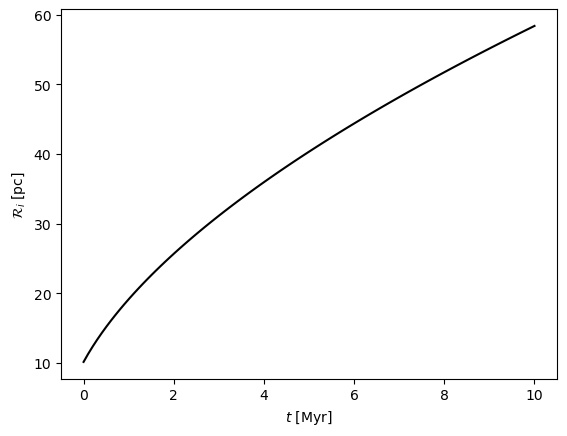

In [8]:
tlin = np.linspace(0, 10, 100) * u.Myr

plt.plot(tlin, sp_bub.radius(tlin), 'k')

plt.xlabel(r'$t$ $[{\rm Myr}]$')
plt.ylabel(r'$\mathcal{R}_i$ $[{\rm pc}]$')

We can also get several key quantities we may be interested in in the bubble, such as its associated Stromgren radius or it's dynamical expansion time:

In [9]:
# stromgren radius
sp_bub.RSt

<Quantity 10.14814006 pc>

In [10]:
# initial dynamical expansion time
sp_bub.tdio

<Quantity 0.8593373 Myr>

# Wind-Blown Bubbles

Wind-Blown Bubbles (WBBs) are characterized by a wind mass-loss rate $\dot{M}_w$ and wind velocity $V_{w}$, which jointly determine the mechanical luminosity of the wind $L_w = \frac{1}{2}\dot{M}_w V_w^2$ and the momentum input rate $\dot{p}_w = \dot{M}_w V_w$. Bubbles blown by these winds have a few different stages. They first expand ballisitically, sweeping up the surrounding gas until the inertia of the swept-up material is comparable to the inertia of the wind. This occurs at a "shock radius"

$R_{w, {\rm shock}} = \sqrt{\frac{\dot{M}_w}{4\pi \overline{\rho} V_w}}
                    = 4.74 \times 10^{-2}\, {\rm pc} \left(\frac{\dot{M}_w}{100 \, M_{\odot}\, {\rm Myr}^{-1}} \right)^{1/2}
                    \left( \frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}}\right)^{-1/2} \left( \frac{V_w}{10^3\, {\rm km/s}}\right)^{-1/2}$

this occurs at the shock time

$t_{w, {\rm shock}} = \sqrt{\frac{\dot{M}_w}{4\pi \overline{\rho} V_w^3}}
                    = 4.64 \times 10^{-5}\, {\rm Myr} \left(\frac{\dot{M}_w}{100 \, M_{\odot}\, {\rm Myr}^{-1}} \right)^{1/2}
                    \left( \frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}}\right)^{-1/2} \left( \frac{V_w}{10^3\, {\rm km/s}}\right)^{-3/2}$

we can calculate these as

In [11]:
Mdotw = 1e-4*u.Msun/u.yr
nH = 100/(u.cm**3)
muH = 1.4
rho = nH * muH * ac.m_p
Vwind = 1e3*u.km/u.s
print("R_w,shock = ", quantities.Rwshock(Mdotw, rho, Vwind))
print("t_w,shock = ", quantities.Twshock(Mdotw, rho, Vwind).to(u.yr))

R_w,shock =  0.04742229677734012 pc
t_w,shock =  46.36915292312112 yr


As one can readily see, this happens at an extremely small length scale and at an extremely early time for typical parameters. This makes this earliest phase pretty much irrelevant for any dynamical evolution of the wind-blown bubble. As the name suggests, after this point the wind interior can no longer expand at the wind velocity, at which point it shocks. At this point it follows a self-similar solution given by Section II of Weaver et al. (1977) until the outer shell is able to cool and form a thin-shell. This occurs at the shell-cooling time which is roughly defined by the time at which the age of the system is comparable to the cooling time of gas in the shell 

$t_{\rm sh, cool} = \frac{3 n_{\rm H}k_BT}{n_e^2 \Lambda(T)}$

where $\Lambda(T)$ is the cooling function, assumed to be a function only of temperature over the parameter regime of interest. In the above we have assumed the gas is fully ionized and therefore $n = 2n_{\rm H}$ and $n_{\rm H} = n_e$ with negligible contribution from the metals in the number density or electron density. 

We can calculate this assuming the simplified, power-law cooling function of Mac-Low & McCray 1988, which gives the shell cooling time as written in Equation 8 of that paper.

In [12]:
Mdotw = 1e-4*u.Msun/u.yr
nH = 100/(u.cm**3)
muH = 1.4
rho = nH * muH * ac.m_p
Vwind = 1e3*u.km/u.s

Lwind = 0.5 * Mdotw * Vwind**2
quantities.Tcool(nH, Lwind).to(u.yr)

<Quantity 625.5408859 yr>

Clearly this is also a very short period of time compared to the evolution time-scales of GMCs. After this point the WBB follows the ``classical" Weaver solution as laid out in Section III of Weaver et al. 1977. In particular, the evolution is solved for assuming that the shell (which has now had a chance to cool) is very thin and writing down a momentum equation for the momentum of this shell along with equations for the internal energy of the bubble.

This leads to the following evolution for the WBB's radius and the momentum carried in the shell (Equations 1 & 3, without factors of $(1-\theta)$ to denote cooling losses)

$R_{\rm ED} (t) = \left( \frac{125}{154\pi}\frac{\mathcal{L}_w t^3}{\overline{\rho}} \right)^{1/5} $

$p_{r, {\rm ED}}(t) = \frac{4\pi}{5} \left( \frac{125}{154 \pi}\right)^{4/5}
    \left(\mathcal{L}_w^4 \overline{\rho} t^7 \right)^{1/5}$

Where we have used the subscript ED to denote ``energy driven.'' That is because this model assumes that the only way for the WBB to lose energy is through mechanical work on its surroundings. In this scenario, WBBs are therefore very efficient at imparting momentum to their surroundings and thus dispersing the clouds in which these stars form.

We can create an instance of what this bubble evolution would look like using the `EnergyDrivenWind()` class in `fb_models.py`

In [13]:
Mdotw = 1e-4*u.Msun/u.yr
nH = 100/(u.cm**3)
muH = 1.4
rho = nH * muH * ac.m_p
Vwind = 1e3*u.km/u.s

Lwind = 0.5 * Mdotw * Vwind**2
ed_wbb = fb_models.EnergyDrivenWind(Lwind=Lwind, rho0=rho)

We can then compare this to the evolution of Spitzer-like photo-ionized gas bubble using the `fb_models.Spitzer()` class we introduced above.

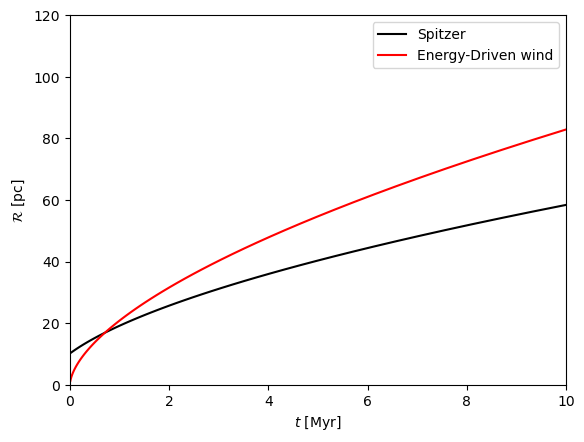

In [14]:
Q0 = 4e50/u.s
# mean molecular weight
# this is what is assumed in the code
muH = 1.4
# number density of hydrogen nuclei
nH = 100/(u.cm**3)
# mean background density
rho = nH * muH * ac.m_p

sp_bub = fb_models.Spitzer(Q0=Q0, rho0=rho)

tlin = np.logspace(-2, 1, 100) * u.Myr

plt.plot(tlin, sp_bub.radius(tlin), 'k', label='Spitzer')
plt.plot(tlin, ed_wbb.radius(tlin), 'r', label='Energy-Driven wind')

plt.xlabel(r'$t$ $[{\rm Myr}]$')
plt.ylabel(r'$\mathcal{R}$ $[{\rm pc}]$')
plt.xlim(0,10)
plt.ylim(0,120)
plt.legend()

We see that the Energy-Driven Wind quickly over-takes the Spitzer-like photo-ionized gas bubble. We can also examine the momentum imparted by each bubble:

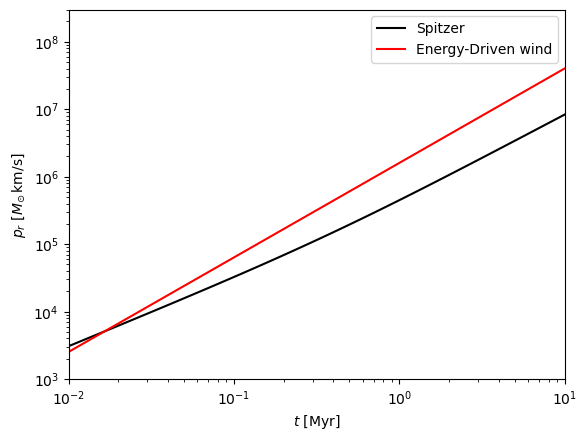

In [15]:
plt.plot(tlin, sp_bub.momentum(tlin), 'k', label='Spitzer')
plt.plot(tlin, ed_wbb.momentum(tlin), 'r', label='Energy-Driven wind')

plt.xlabel(r'$t$ $[{\rm Myr}]$')
plt.ylabel(r'$p_r$ $[M_{\odot}\, {\rm km/s}]$')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-2,10)
plt.ylim(1e3,3e8)
plt.legend()

The momentum of the Energy-Driven Wind Bubble is nearly always dominant to that of the photo-ionized gas.

If the WBB is able to efficiently lose energy through another means its shocked wind region will become very under-preddurized and it can enter the momentum-driven regime, where the important parameter for the evolution is then $\dot{p}_w$ instead of $\mathcal{L}_w$. This energy loss can happen in many ways: (i) enhanced cooling in the WBB interior facilitated by mass-loading of the interior through conductive evaporation at the surface (as in the Weaver et al. paper), (ii) bulk advection of the hot, shocked gas through low-density channels (as in Harper-Clark & Murray 2009), or (iii) rapid cooling in turbulently mixed gas at the WBB interface (as in Lancaster et al. 2021a,b).

We can investigate the momentum-driven regime here using the `fb_models.MomentumDrivenWind()` class:



In [16]:
Mdotw = 1e-4*u.Msun/u.yr
nH = 100/(u.cm**3)
muH = 1.4
rho = nH * muH * ac.m_p
Vwind = 1e3*u.km/u.s

pdotw = Mdotw * Vwind
md_wbb = fb_models.MomentumDrivenWind(pdotw=pdotw, rho0=rho)

And we can make the same comparison plots:

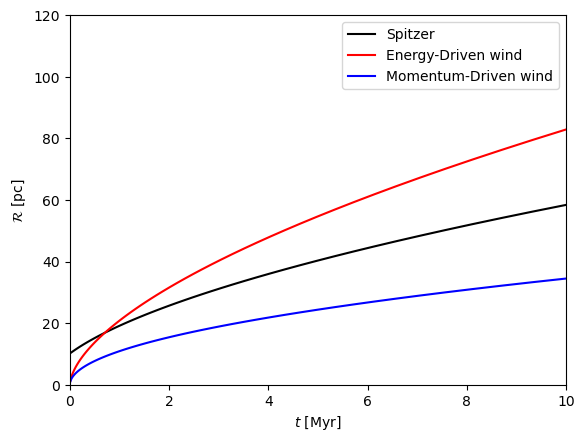

In [17]:
tlin = np.logspace(-2, 1, 100) * u.Myr

plt.plot(tlin, sp_bub.radius(tlin), 'k', label='Spitzer')
plt.plot(tlin, ed_wbb.radius(tlin), 'r', label='Energy-Driven wind')
plt.plot(tlin, md_wbb.radius(tlin), 'b', label='Momentum-Driven wind')

plt.xlabel(r'$t$ $[{\rm Myr}]$')
plt.ylabel(r'$\mathcal{R}$ $[{\rm pc}]$')
plt.xlim(0,10)
plt.ylim(0,120)
plt.legend()

We see that, for the parameters chosen here, the radial evolution of the Momentum-Driven wind is much reduced compared to the Energy-Driven solution and is even smaller than the Spitzer-like bubble.

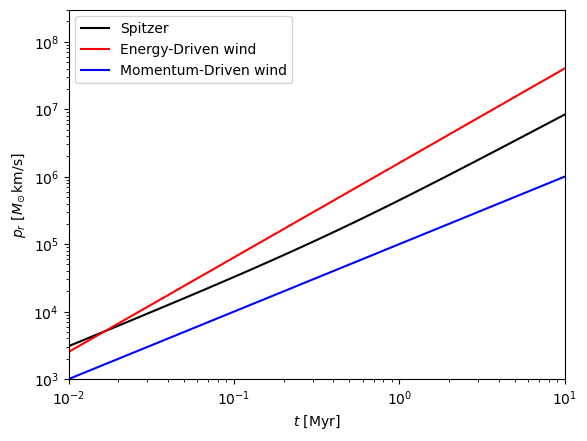

In [18]:
tlin = np.logspace(-2, 1, 100) * u.Myr

plt.plot(tlin, sp_bub.momentum(tlin), 'k', label='Spitzer')
plt.plot(tlin, ed_wbb.momentum(tlin), 'r', label='Energy-Driven wind')
plt.plot(tlin, md_wbb.momentum(tlin), 'b', label='Momentum-Driven wind')

plt.xlabel(r'$t$ $[{\rm Myr}]$')
plt.ylabel(r'$p_r$ $[M_{\odot}\, {\rm km/s}]$')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-2,10)
plt.ylim(1e3,3e8)
plt.legend()

Again, for these choices of parameters, the momentum-driven WBB is slightly smaller thatn the evolution of the photo-ionized gas bubble.

# Co-Evolution Models

In the above we have described WBBs and the photo-ionized gas as evolving separately, unaware of one another. In reality these two feedback mechanisms always co-exist and they effect one another in time-dependent ways, precluding the somewhat scale-free solutions given above. In Lancaster et al. 2025a we introduce two Co-Evolution Models (CEMs) for how an Energy-Driven or Momentum-Driven WBB would evolve together with the photo-ionized gas that surrounds it. These models account for the pressure force exerted on the WBB by the photo-ionized gas and the way that the WBB compresses the photo-ionized gas, reducing its size by increasing its recombination rate.

Both models are characterized by the equilibrium radius, $R_{\rm eq}$: the radius at which the classical WBB evolution would be at the initial pressure of the photo-ionized gas:

$P_w \left(R_{\rm eq}\right) = \overline{\rho} c_i^2$

where $P_w$ in the above is the pressure of the hot WBB gas in either the energy- or momentum-driven solutions. We can calulate each of these for the momentum and energy-driven WBBs as (Equation 21/B19 & 23/B22):

$R_{\rm eq, MD} = \sqrt{\frac{\dot{p}_w}{4\pi \overline{\rho} c_i^2}}
        =4.74\, {\rm pc} \, \left(\frac{\dot{p}_w}{10^5 \, M_{\odot}\, {\rm km/s/Myr}} \right)^{1/2}
        \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-1/2} 
        \left( \frac{c_i}{10\, {\rm km/s}}\right)^{-1}$

$R_{\rm eq, ED} = \sqrt{\frac{\sqrt{7}\mathcal{L}_w}{22\pi \overline{\rho} c_i^3}} = 
    41.4\, {\rm pc} \left(\frac{\mathcal{L}_w}{10^{38} \, {\rm erg/s}} \right)^{1/2} 
    \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-1/2} 
    \left( \frac{c_i}{10\, {\rm km/s}}\right)^{-3/2}$

which we can calculate in using functions in `quantities.py` as:

In [19]:
pdotw = 1e5*u.Msun*u.km/u.s/u.Myr
nH = 100/(u.cm**3)
muH = 1.4
rho = nH * muH * ac.m_p
Lwind = 1e38*u.erg/u.s
ci = 10*u.km/u.s

ReqMD = quantities.Req_MD(pdotw, rho, ci=ci)
print("R_{eq, MD} = ", ReqMD)
ReqED = quantities.Req_ED(Lwind, rho, ci=ci)
print("R_{eq, ED} = ", ReqED)

R_{eq, MD} =  4.742229677734012 pc
R_{eq, ED} =  41.435709316846705 pc


This equilibrium is achieved at the equilibrium time $t_{\rm eq}$ at which the classical WBB solutions reach these radii, which can be calculated for each of the models as (Equations 22/B20 & 24/B23):

$t_{\rm eq,MD} \equiv \frac{1}{6 c_i^2} \sqrt{\frac{3}{2\pi} \frac{\dot{p}_w}{\overline{\rho}}}
    = \frac{R_{\rm eq,MD} }{\sqrt{6}c_i}
    = 1.89 \times 10^5 \, {\rm yr}\, 
    \left(\frac{\dot{p}_w}{10^5 \, M_{\odot}\, {\rm km/s/Myr}} \right)^{1/2} 
    \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-1/2} 
    \left( \frac{c_i}{10\, {\rm km/s}}\right)^{-2}$

$t_{\rm eq,ED} = \frac{7^{3/4}}{5} \sqrt{\frac{\mathcal{L}_w}{22\pi \overline{\rho} c_i^5}}
    = \frac{\sqrt{7}}{5} \frac{R_{\rm eq,ED}}{c_i}
    = 2.14 \, \times 10^6 \,{\rm yr} \left(\frac{\mathcal{L}_w}{10^{38} \, {\rm erg/s}} \right)^{1/2} 
    \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-1/2} 
    \left( \frac{c_i}{10\, {\rm km/s}}\right)^{-5/2}$

which can also be calculated using functions in the `quantities.py` file:

In [20]:
pdotw = 1e5*u.Msun*u.km/u.s/u.Myr
nH = 100/(u.cm**3)
muH = 1.4
rho = nH * muH * ac.m_p
Lwind = 1e38*u.erg/u.s
ci = 10*u.km/u.s

teqMD = quantities.Teq_MD(pdotw, rho, ci=ci)
print("t_{eq, MD} = ", teqMD)
teqED = quantities.Teq_ED(Lwind, rho, ci=ci)
print("t_{eq, ED} = ", teqED)

t_{eq, MD} =  0.1893012741112164 Myr
t_{eq, ED} =  2.1438794999576487 Myr


We characterize the co-evolution models using $\zeta \equiv R_{\rm eq}/R_{\rm St}$. For $\zeta \ll 1$ the WBB comes into equilibrium with the photo-ionized gas long before it has much disturbed the gas, this is the photo-ionized gas dominated limit. For $\zeta \gg 1$ the WBB is still over-pressurized when it reaches $R_{\rm St}$ and so it sweeps up all of the surrounding photo-ionized gas into a thin shell surrounding it, this is WBB dominated limit.

The CEMs we develop in Lancaster+25a have two phases: (1) an Early Phase during which the WBB and photo-ionized gas evolve independently according to their idealized, classical solutions and (2) a Co-Evolution Phase during which each feels the impact of the other. The breaking up of the evolution into two distinct phases is of course an approximation that is given further justification in the text. In the $\zeta < 1$ regime, this transition occurs at $t = t_{\rm eq}$, the first reasonable time we would expect the WBB to be in pressure equilibrium with the photo-ionized gas.

For $\zeta > 1$ the WBB may catch up with the photo-ionized gas at some catch-up time, $t_{\rm catch}$, where $R_w(t_{\rm catch}) = R_{\rm Sp}(t_{\rm catch})$, before the equilibrium radius is reached (that is, it is possible for $t_{\rm catch} < t_{\rm eq}$). In this scenario we choose the minimum of $t_{\rm eq}$ and $t_{\rm catch}$ as the time when the Co-Evolution Phase begins. Deep into this regime $\zeta \gg 1$ the feedback bubble is essentially a WBB with a very thin layer of photo-ionized gas in its shell, so the CEMs presented here are of somewhat less use as the dynamics could essentially be predicted by following the dynamcis of the WBB alone.

We can use the `fb_models.MD_CEM()` and `fb_models.ED_CEM()` to investigate the dynamics of the momentum-driven and energy driven CEMs respectively and compare them as:

In [21]:
nbar = 100*u.cm**-3
rhobar = 1.4*ac.m_p*nbar
appdot = 1e5*u.Msun*u.km/u.s/u.Myr
Lwind = 1e38*u.erg/u.s
Qo = 4e50/u.s

model1 = fb_models.MD_CEM(rho0=rhobar, Q0=Qo, pdotw=appdot)
model2 = fb_models.ED_CEM(rho0=rhobar, Q0=Qo, Lwind=Lwind)
print("zeta_MD = ", model1.zeta)
print("zeta_ED = ", model2.zeta)

zeta_MD =  0.4673003772695028
zeta_ED =  4.083084100102915


We see that, for these parameters, both CEMs are in the regime ($\zeta \sim 1$) where both WBBs and the photo-ionized gas are dynamically important. We can take a look at their evolution below:

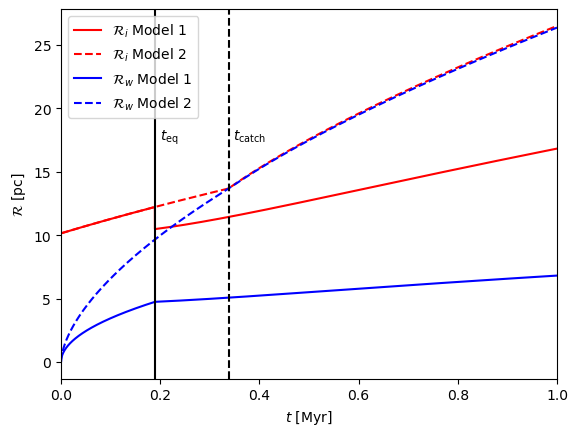

In [22]:

tlin = np.linspace(0, 1, 10000)*u.Myr

plt.plot(tlin, model1.radius(tlin), 'r',label=r'$\mathcal{R}_i$ Model 1')
plt.plot(tlin, model2.radius(tlin), 'r--',label=r'$\mathcal{R}_i$ Model 2')

plt.plot(tlin, model1.wind_radius(tlin), 'b',label=r'$\mathcal{R}_w$ Model 1')
plt.plot(tlin, model2.wind_radius(tlin), 'b--',label=r'$\mathcal{R}_w$ Model 2')

plt.axvline(x=model1.tswitch.value, c="k")
plt.axvline(x=model2.tswitch.value, c="k", linestyle='--')

plt.text(1.05*model1.tswitch.value, 17.5, r'$t_{\rm eq}$')
plt.text(1.025*model2.tswitch.value, 17.5, r'$t_{\rm catch}$')

plt.xlim(0,1)
plt.xlabel(r'$t\,\, [{\rm Myr}]$')
plt.ylabel(r'$\mathcal{R}\,\, [{\rm pc}]$')
plt.legend()


The solid lines denote the MD-CEM and the dashed lines denote the ED-CEM. WBB radii are shown in blue, ionized gas radii in red, and the transition between the early and co-evolution phases are shown as vertical black lines.

In the MD-CEM (solid lines), the transition occurs at $t = t_{\rm eq}$ (since $\zeta < 1$): the WBB evolution is then suppressed as it begins to feel the pressure of the photo-ionized gas around it. The photo-ionized gas region also shrinks as it feels the compression of the WBB and is forced to higher density and therefore recombines more quickly. This occurs discontinuously, which is an artifact of forcing the instantaneous transition, see Lancaster+25a for details.

In the ED-CEM (dashed lines), the transition occurs at $t=t_{\rm ot}$, when the WBB "runs in to" the classical photo-ionized gas solution, as indicated by the dashed blue line intersecting the dashed red line. At this point the photo-ionized gas radius is also discontinuously changed, but now it is made larger as it is being forced to larger radii by the pressure of the WBB. The fact that the WBB evolution does not seem to drastically differ from its evolution in the early phase is also indicative of the dominant dynamical role of the WBB in this scenario.